<a href="https://colab.research.google.com/github/MuhammadTanveerm/Payment-Transaction-Fruad-Detection/blob/main/Payment_Transaction_Fruad_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Goal.**

Payment Transaction Fruad Detection:
    Score incoming tranaction with an** anomaly / risk score **and raise alerts for manual reivew or automated blocking.

# **Import Libraires**

In [5]:
import pandas as pd
import numpy as np
import os, math,  joblib
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, average_precision_score,  precision_recall_curve

from sklearn.model_selection import  train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as  plt

# **Load Dataset**

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning/ML Projects/Paymet Transaction Fruad Detection/creditcard.csv")

# **Exploratory Data Analysis**

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
print(df.shape)
countsf_class = df['Class'].value_counts(normalize=True)
print(countsf_class)

print(df.isnull().sum())

(284807, 31)
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


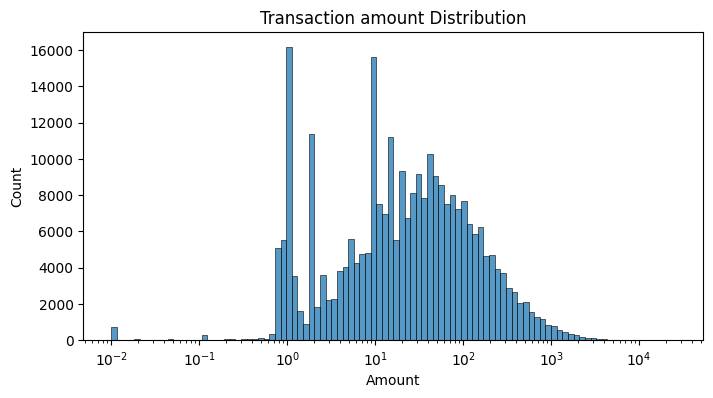

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=100, log_scale=[True,False])
plt.title("Transaction amount Distribution")
plt.show()

# **Feature Engineering** (simple and effective)

In [16]:
df['log_amount'] = np.log1p(df['Amount'])
df['hour'] = (df['Time'] // 3600) % 24
features = [f'V{i}' for i in range(1,29)] + ['log_amount', 'hour']
X = df[features].fillna(0)

y = df['Class'].values

**Scale numeric values**

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Why:  IsolationForest , LOF, Neural networks work better when inputs are standardized

# **Train Test Split**

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.20, random_state=40, stratify=y)

# **Model A: IsolationForest (fast baseline )**

In [22]:
iso = IsolationForest(n_estimators=200,
                      max_samples='auto',
                      contamination=0.0018,  # ~ expected fraud rate; tune with business
                      random_state=42)
iso.fit(X_train)
iso_scores = -iso.decision_function(X_val)  # higher => more anomalous

In [23]:
print(iso_scores)

[-0.26939846 -0.24947809 -0.23985569 ... -0.23556771 -0.29052867
 -0.21076106]


**Evalution**

In [24]:
print(f'ROC - AUC (iso)', roc_auc_score(y_val, iso_scores))
print(f'Average precision',  average_precision_score(y_val, iso_scores))

ROC - AUC (iso) 0.9445224840076717
Average precision 0.15847070609614006


# **Model B : Autoencoder (deep unsupervised)**

In [32]:
input_dim = X_train.shape[1]
inp = layers.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(inp)
x = layers.Dense(64, activation='relu')(x)
encoded = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(encoded)
x = layers.Dense(128, activation='relu')(x)
decoded = layers.Dense(input_dim, activation='linear')(x)

ae = models.Model(inp, decoded)
ae.compile(optimizer='adam', loss='mse')


**Train**

In [33]:
history = ae.fit(X_train, X_train,
                 epochs=30,
                 batch_size=2048,
                 validation_data=(X_val, X_val),
                 verbose=1)


Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.7751 - val_loss: 0.1824
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1280 - val_loss: 0.0480
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0442 - val_loss: 0.0288
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0275 - val_loss: 0.0209
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0202 - val_loss: 0.0165
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0162 - val_loss: 0.0146
Epoch 7/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0135 - val_loss: 0.0120
Epoch 8/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 9/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0109 - val_loss: 0.0101
Epoch 10/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 11/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 12/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 

Anomlay Score: reconstruction MSE per **sample**

In [34]:
recon_val = ae.predict(X_val)
mse_val = np.mean(np.square(X_val - recon_val), axis=1)
print("ROC-AUC (ae):", roc_auc_score(y_val, mse_val))
print("Average Precision (ae):", average_precision_score(y_val, mse_val))


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
ROC-AUC (ae): 0.9576870844004457
Average Precision (ae): 0.30722464589016335


Save **Model**

In [35]:
ae.save('autoencoder_model.h5')


# Model C: Local Outlier Factor (LOF)

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0018, novelty=True)
lof.fit(X_train)
lof_scores = -lof.decision_function(X_val)  # higher = more anomalous
print("ROC-AUC (lof):", roc_auc_score(y_val, lof_scores))
print("Average Precision (lof):", average_precision_score(y_val, lof_scores))


# **See normalization and ensemble (recommended)**
Each model score different scale , normalize into [0,1]

In [ ]:
def minmax_norm(arr):
    arr = np.array(arr)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-9)

iso_n = minmax_norm(iso_scores)
ae_n  = minmax_norm(mse_val)
lof_n = minmax_norm(lof_scores)

ensemble_score = 0.5*ae_n + 0.3*iso_n + 0.2*lof_n
print("ROC-AUC (ensemble):", roc_auc_score(y_val, ensemble_score))
print("Average Precision (ensemble):", average_precision_score(y_val, ensemble_score))
